In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!sudo apt-get install libportaudio2
!pip install sounddevice

In [3]:
import os
import numpy as np
import pylab as plt
import scipy.signal as sg
import pandas as pd

from IPython.display import Audio, display
def play(x, fs):
    display(Audio(x, rate=fs))
    
plt.rcParams["figure.figsize"] = (8,2)
plt.rcParams["figure.dpi"] = 150

data_dir = '/content/drive/MyDrive/НИС АДИС 2022/data_project/'
def load_sample(n):
    return np.load(os.path.join(data_dir, 'train.npz'))['x'][n]

fs = 16000


(5000.0, 8000.0)

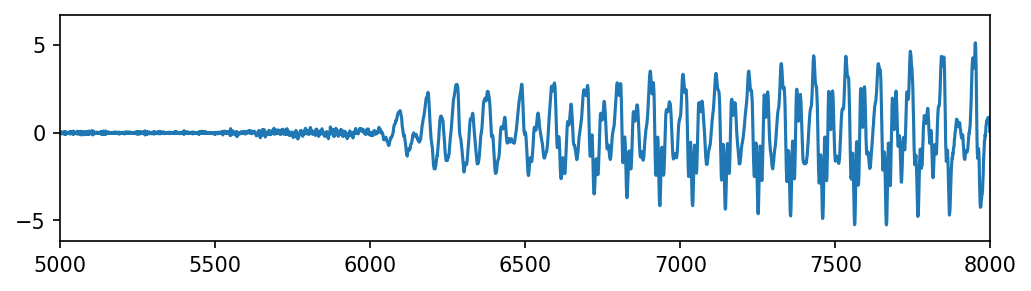

In [14]:
# let's look at the sample

x = load_sample(3)
play(x, fs)

plt.plot(x)

plt.xlim(5000, 8000)


(6000.0, 7000.0)

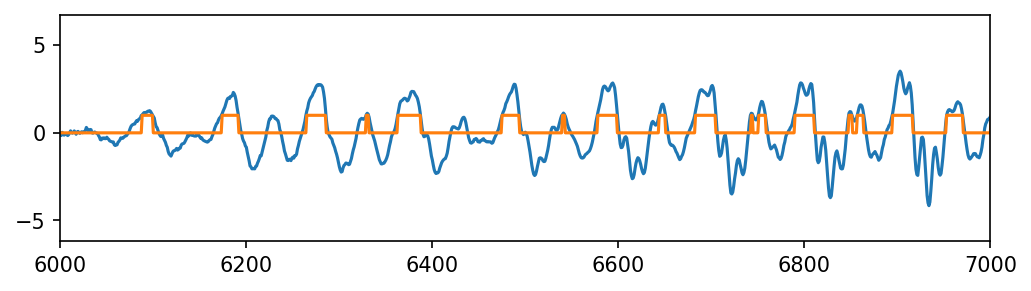

In [29]:
# Simple threshold
plt.plot(x)
plt.plot((x>1)*1)
# plt.xlim(6000, 7000)

(6000.0, 7000.0)

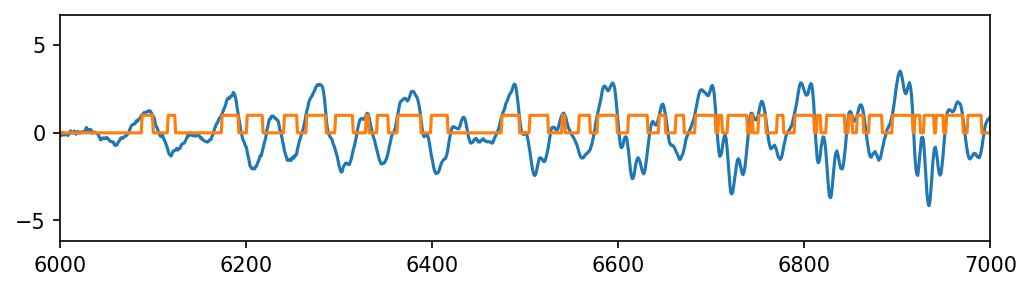

In [30]:
# Abs threshold
plt.plot(x)
plt.plot((abs(x)>1)*1)
plt.xlim(6000, 7000)

(6000.0, 7000.0)

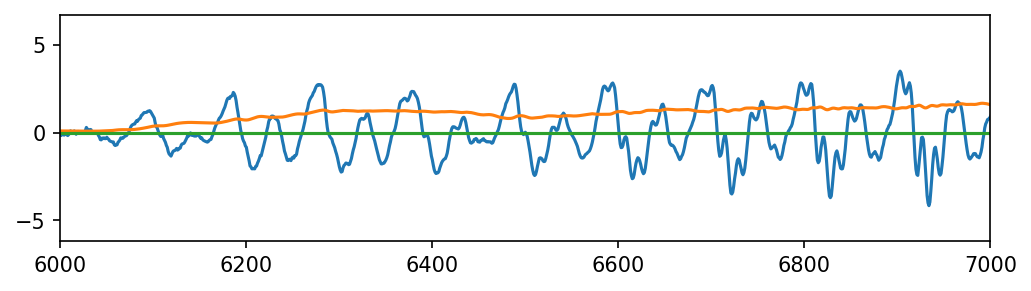

In [35]:
# Moving average

N = 100
b = np.ones(N)/N
a = [1]

y = sg.lfilter(b, a, np.abs(x))

z = np.zeros(len(x))

plt.plot(x)
plt.plot(y)
plt.plot(z)

plt.xlim(6000, 7000)

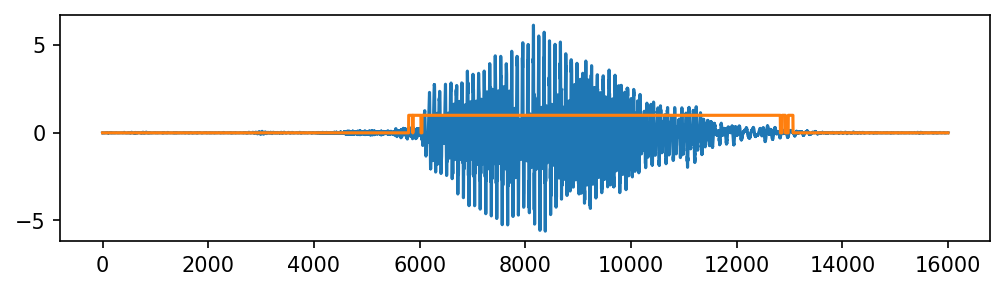

In [38]:
# Masked moving average

# try different thresholds (1, 0.1)
# try different N (100, 1000)

N = 100
b = np.ones(N)/N
a = [1]

y = sg.lfilter(b, a, np.abs(x))

plt.plot(x)
plt.plot((y>0.1)*1)

# plt.xlim(6000, 7000)

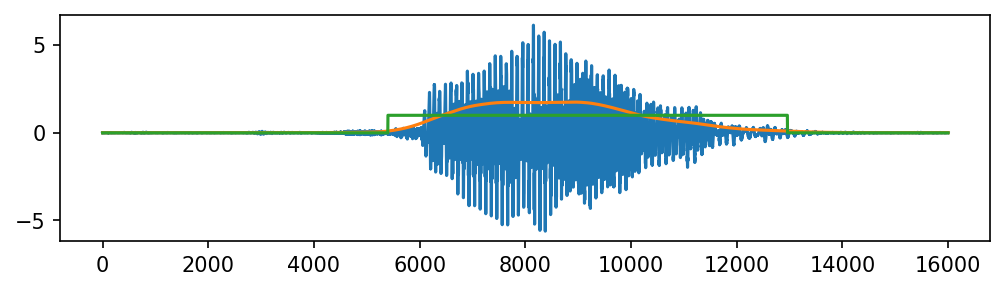

In [43]:
# Masked moving average with "future" information
# let's use scipy.signal.filtfilt

# note: scipy.signal.lfilter uses only "past" information

# try different thresholds (1, 0.1)
# try different N (100, 1000)

N = 1000
b = np.ones(N)/N
a = [1]

y = sg.filtfilt(b, a, np.abs(x))

plt.plot(x)
plt.plot(y)
plt.plot((y>0.1)*1)

# plt.xlim(6000, 7000)

#### Voice activity detector (VAD)

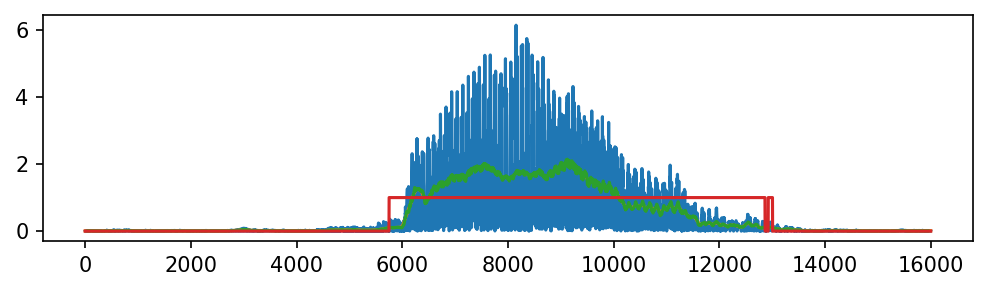

In [52]:
# Use pd.Series method rollig for moving average

N = 100
b = np.ones(N)/N
a = [1]

y = sg.filtfilt(b, a, np.abs(x))

y_1 = pd.Series(np.abs(x)).rolling(window=N, center=True).mean() #moving average
# y_1 = pd.Series(np.abs(x)).rolling(window=N, center=True).max() #compute envelope


plt.plot(abs(x))
plt.plot(y)
plt.plot(y_1)
plt.plot((y>0.1)*1)

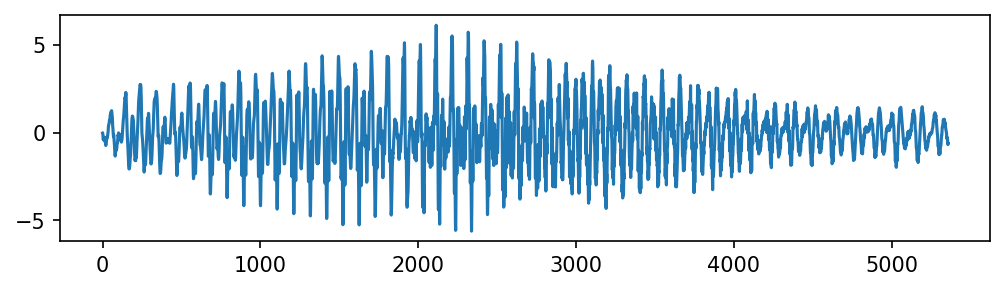

In [53]:
y_1 = pd.Series(np.abs(x)).rolling(window=N, center=True).max() #compute envelope

plt.plot(x[y_1>1])
play(x[y_1>1], fs)

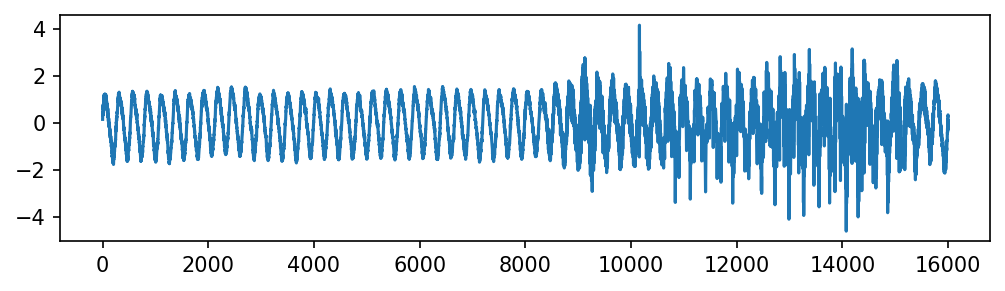

In [54]:
# Noisy example, VAD fail
x = load_sample(4)

plt.plot(x)
play(x, fs)

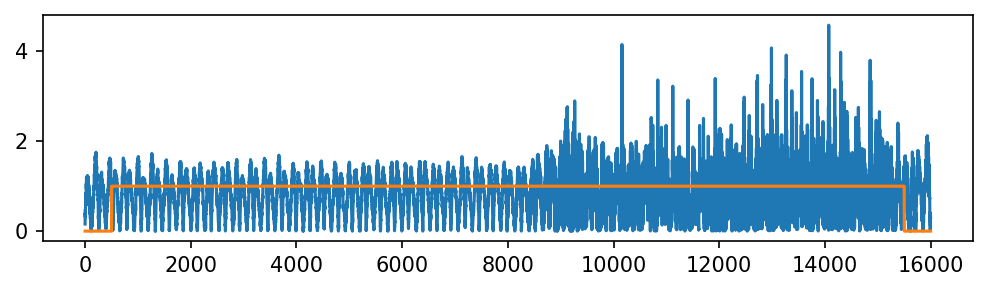

In [56]:
# apply VAD method

y_1 = pd.Series(np.abs(x)).rolling(window=1000, center=True).max()

plt.plot(np.abs(x))
plt.plot(y_1 > 1)

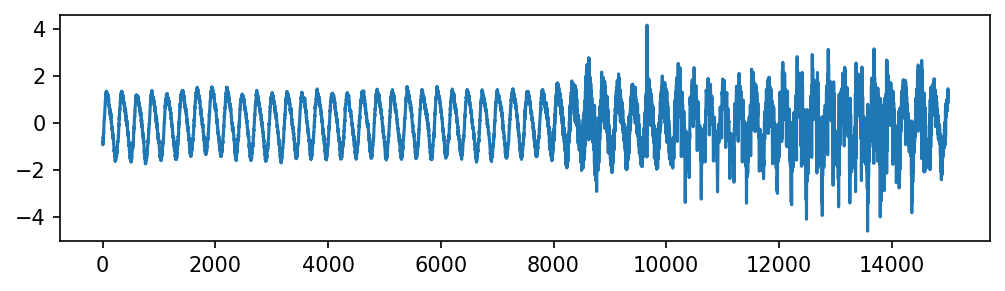

In [57]:
plt.plot(x[y_1>1])
play(x[y_1>1], fs)

(0.0, 2000.0)

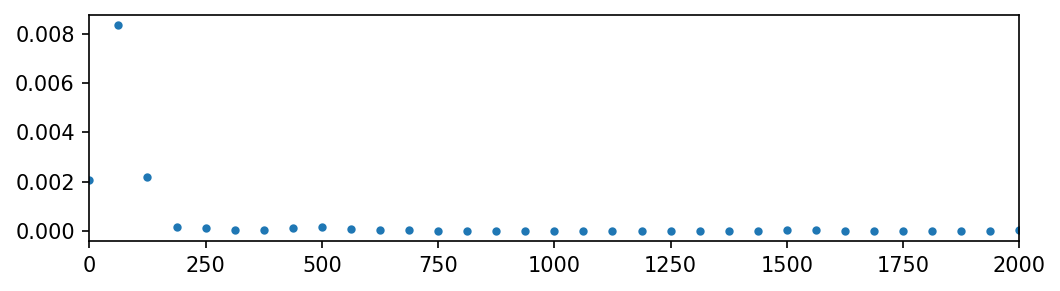

In [64]:
# Noize detection with Welch method (mean(abs(Fourier transform)) in each time window)
# Result: power spectral density
freq, spec = sg.welch(x, fs)
plt.plot(freq, spec, '.')
plt.xlim(0, 2000)

# step between frequencies 62.5 Hz!

(0.0, 2000.0)

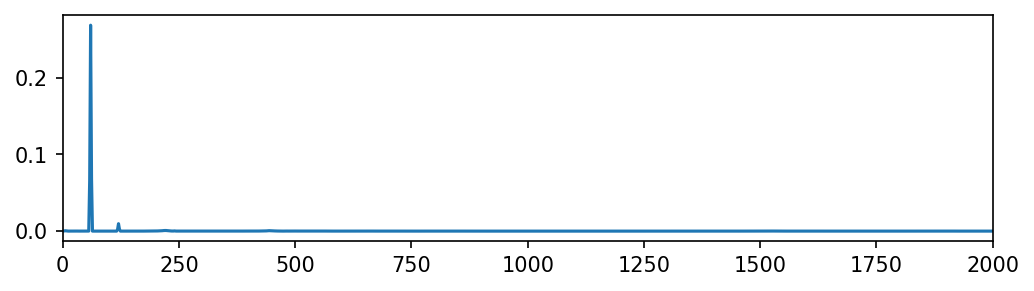

In [66]:
# Add parameters to welch (nperseg, noverlap) to decrease step between freqs

freq, spec = sg.welch(x, fs, nperseg=8000, noverlap=7000)
plt.plot(freq, spec)
plt.xlim(0, 2000)

(0.0, 2000.0)

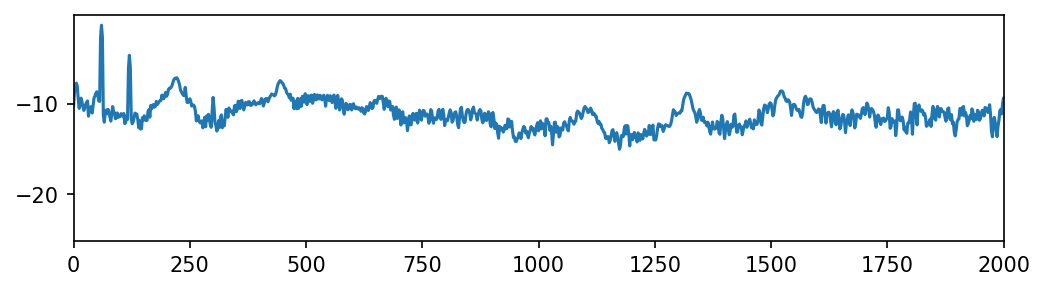

In [68]:
# Let's see log(spectrum)

freq, spec = sg.welch(x, fs, nperseg=8000, noverlap=7000)
plt.plot(freq, np.log(spec))
plt.xlim(0, 2000)

# Two big peaks in low freqs, some fluctuations in higher freqs

(0.0, 250.0)

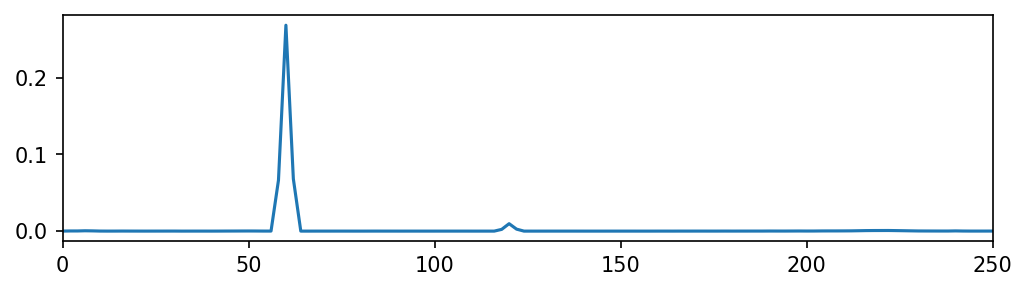

In [69]:
# Two low-freq peaks: 60 Hz, 120 Hz - socket noize 
freq, spec = sg.welch(x, fs, nperseg=8000, noverlap=7000)
plt.plot(freq, spec)
plt.xlim(0, 250)

(0.0, 1000.0)

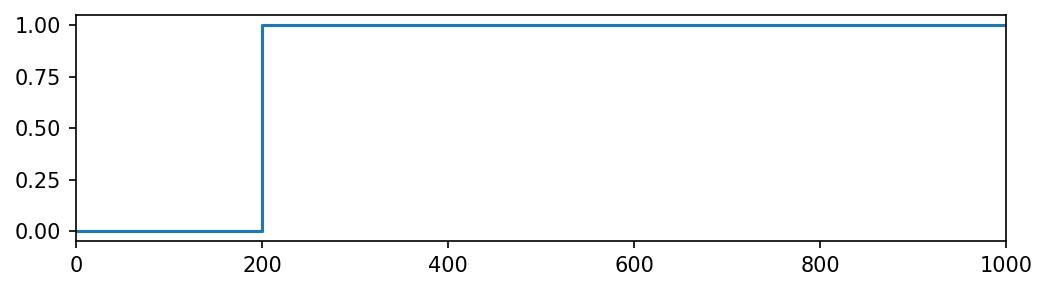

In [70]:
# Let's reduce noize!
# Consider filter:

freqs0 = [0, 200, 200, 8000]
H0 = [0, 0, 1, 1]

plt.plot(freqs0, H0)
plt.xlim(0, 1000)

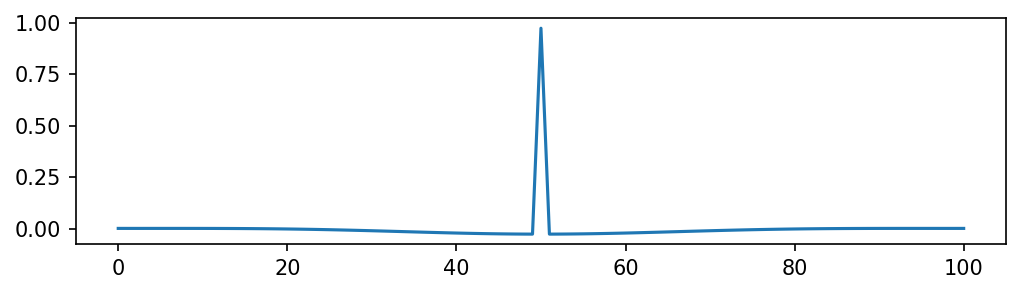

In [75]:
# Desired Mag Response and approx

freqs0 = [0, 200, 200, 8000]
H0 = [0, 0, 1, 1]

b = sg.firwin2(1001, freqs0, H0, fs=fs)
plt.plot(b)

Text(0, 0.5, 'A(freq)')

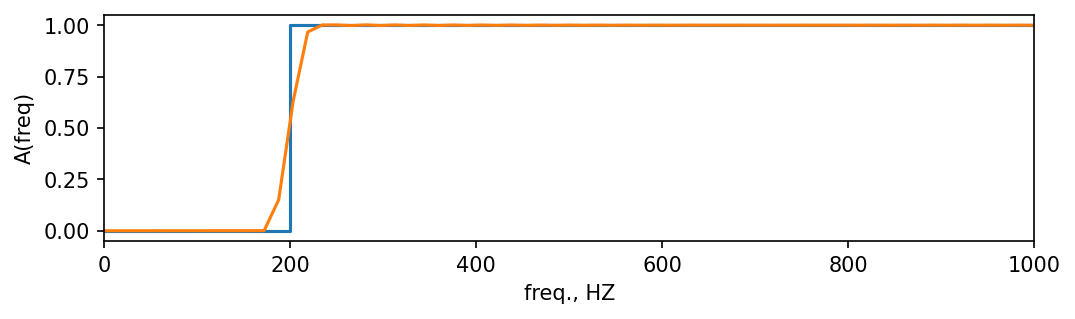

In [88]:
# Show H(omega)

b = sg.firwin2(1001, freqs0, H0, fs=fs) #1st parameter - len(b)

freq, H = sg.freqz(b, fs=fs)

plt.plot(freqs0, H0)
plt.plot(freq, np.abs(H))

plt.xlim(0, 1000)
plt.xlabel('freq., HZ')
plt.ylabel('A(freq)')

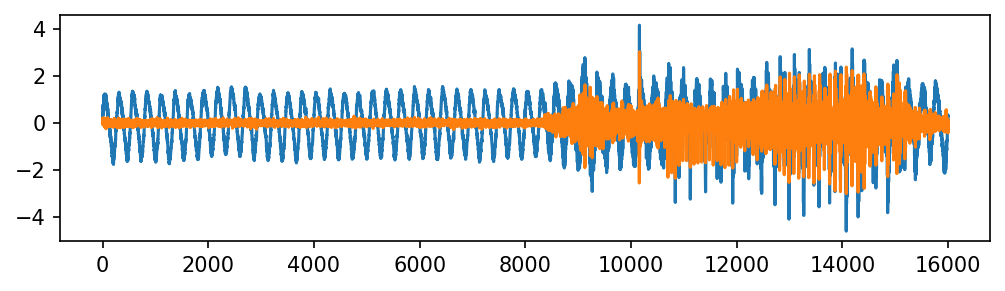

In [89]:
# Filtration result

y = sg.filtfilt(b=b, a=[1.], x=x)

plt.plot(x)
plt.plot(y)
# plt.plot(x-y)

play(x, fs)
play(y, fs)

(0.0, 1000.0)

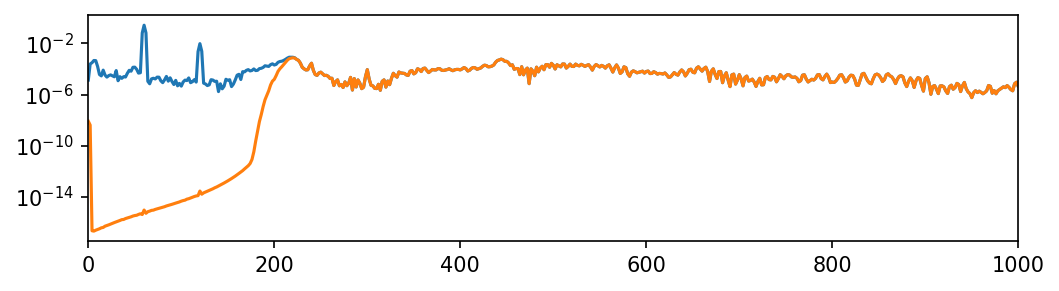

In [91]:
# Compare spec
freq, spec = sg.welch(x, fs, nperseg=8000)
plt.semilogy(freq, spec)

freq, spec = sg.welch(y, fs, nperseg=8000)
plt.plot(freq, spec)

plt.xlim(0, 1000)

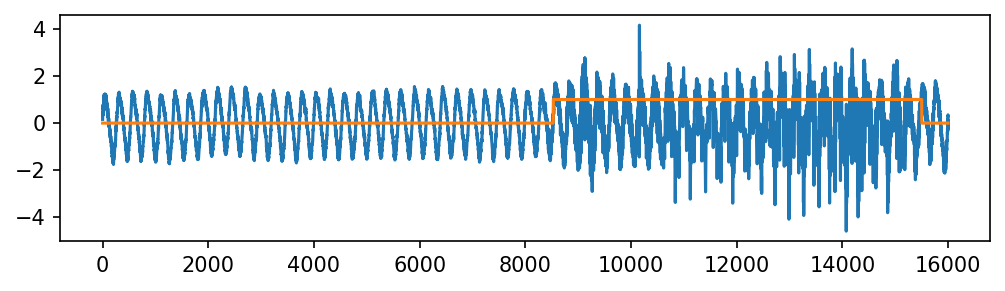

In [95]:
# VAD after filtration

y_1 = pd.Series(np.abs(y)).rolling(window=1000, center=True).max()

plt.plot(x)
plt.plot(y_1 > 1)

Text(0, 0.5, 'A(freq)')

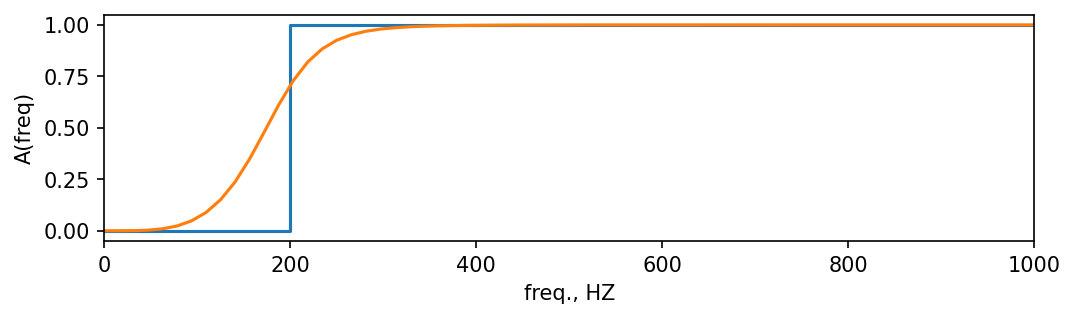

In [99]:
# IIR filter and Mag Response

b, a = sg.butter(4, 200, 'highpass', fs=fs)
# b, a = sg.butter(4, [200, 300], 'bandpass', fs=fs) # 'bandstop'

freqs0 = [0, 200, 200, 8000]
H0 = [0, 0, 1, 1]


freq, H = sg.freqz(b, a, fs=fs)

plt.plot(freqs0, H0)

plt.plot(freq, np.abs(H))
plt.xlim(0, 1000)
plt.xlabel('freq., HZ')
plt.ylabel('A(freq)')

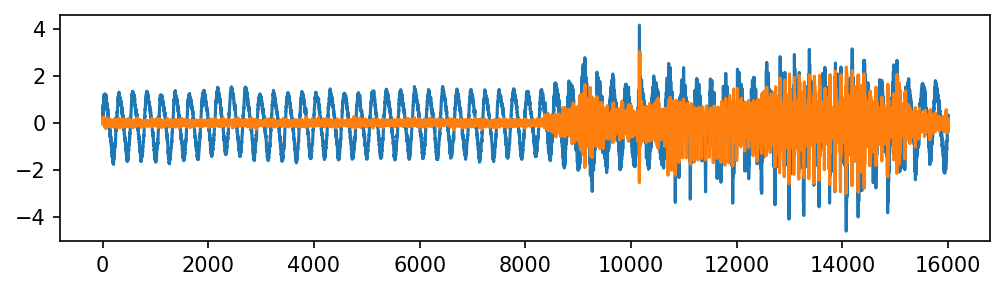

In [97]:
y = sg.filtfilt(b=b, a=a, x=x)
plt.plot(x)
# plt.plot(x-y)
plt.plot(y)

play(y, fs)

Text(0, 0.5, 'A(freq)')

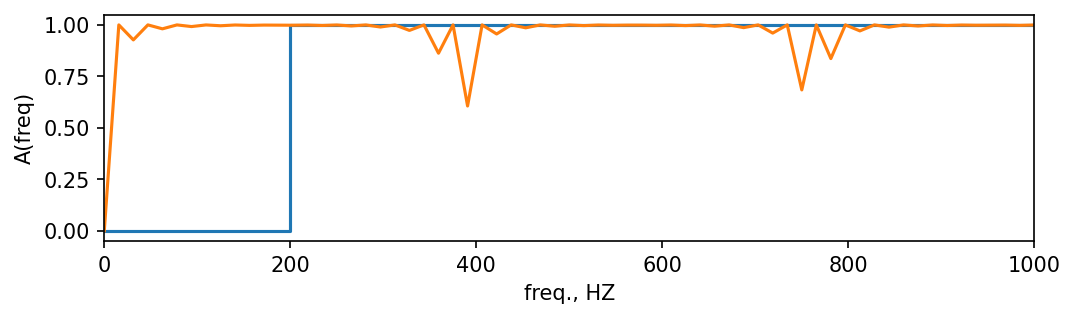

In [101]:
# Comb filter (Notch filter) and Mag Response
b, a = sg.iircomb(60/fs, 30)

freqs0 = [0, 200, 200, 8000]
H0 = [0, 0, 1, 1]

freq, H = sg.freqz(b, a, fs=fs)

plt.plot(freqs0, H0)

plt.plot(freq, np.abs(H))
plt.xlim(0, 1000)
plt.xlabel('freq., HZ')
plt.ylabel('A(freq)')

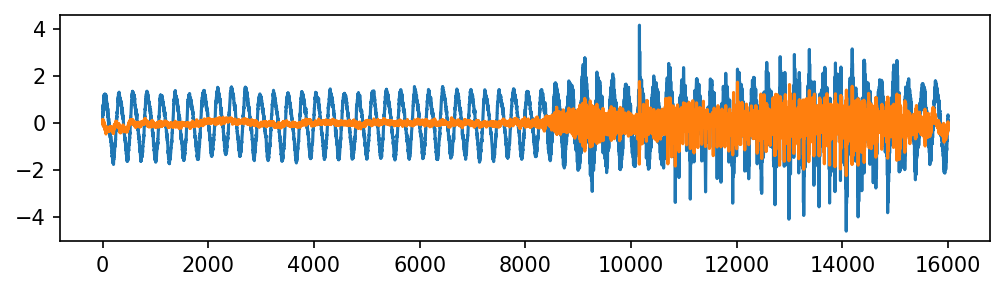

In [106]:
# Apply Comb filter

b, a = sg.iircomb(60/fs, 3)

y = sg.filtfilt(b=b, a=a, x=x)
plt.plot(x)
# plt.plot(x-y)
plt.plot(y)

play(y, fs)

(0.0, 1000.0)

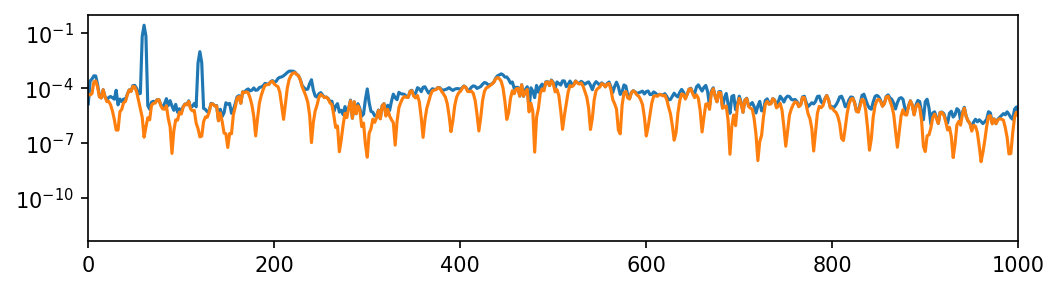

In [107]:
freq, spec = sg.welch(x, fs, nperseg=8000)
plt.semilogy(freq, spec)

freq, spec = sg.welch(y, fs, nperseg=8000)
plt.plot(freq, spec)
plt.xlim(0, 1000)